<a href="https://colab.research.google.com/github/JayThibs/rome-experiments/blob/main/notebooks/rome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/rome.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Notebook Setup

## Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%cd /content/drive/MyDrive

[Errno 2] No such file or directory: '/content/drive/MyDrive'
/home/ubuntu/rome-experiments/notebooks


In [3]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome

In [5]:
%%bash
# git clone https://github.com/kmeng01/rome/ rome > install.log 2>&1
cd rome
# git checkout 697ef6e494536e11c3669a3c3a1aec76c230867b
pip install -r scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [1]:
IS_COLAB = False
ALL_DEPS = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    os.chdir('rome')
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Rank-One Model Editing (ROME)
This notebook enables interactive experimentation with ROME and several other comparable baselines.
The goal is to write new facts (e.g. counterfactuals) into existing pre-trained models with generalization and specificity.

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import json

from util import nethook
from util.generate import generate_interactive, generate_fast

from experiments.py.demo import demo_model_editing, stop_execution

## Loading Model and Tokenizer

Here, you can specify a GPT model (`MODEL_NAME`).

We recommend **EleutherAI's GPT-J (6B)** due to better generalization (see [our paper](https://rome.baulab.info/) for details), but GPT-2 XL (1.5B) consumes less memory.
* `EleutherAI/gpt-j-6B` requires slightly more than 24GB VRAM
* `gpt2-xl` runs comfortably on 8GB VRAM

In [4]:
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B

In [5]:
device = 'cuda'
model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(device),
    AutoTokenizer.from_pretrained(MODEL_NAME)
)
tok.pad_token = tok.eos_token
model.config

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.15.0",
  "use_cache": true,
  "vocab_size": 50257
}

A requested rewrite can be specified using `request`. `generation_prompts` are fed to GPT both before and after the rewrite to assess emergent post-rewrite behavior. See the bottom of this notebook for more examples.


## Loading Data

In [ ]:
with open("./data/counterfact.json") as f:
    counterfact = json.load(f)

with open("./data/known_1000.json") as f:
    known = json.load(f)

In [ ]:
counterfact[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [ ]:
known[1]

{'known_id': 1,
 'subject': 'Beats Music',
 'attribute': 'Apple',
 'template': '{} is owned by',
 'prediction': ' Apple, which is also the owner of Beats Electronics',
 'prompt': 'Beats Music is owned by',
 'relation_id': 'P127'}

In [ ]:
# df = pd.read_json("/content/counterfact.json")
# df.to_csv("/content/counterfact.csv")
# df.to_json('/content/temp.json', orient='records', lines=True)

In [ ]:
# test_dict = df.head().to_dict(orient='records')
# test_dict['requested_rewrite'][0]

In [ ]:
# rew = counterfact[0]['requested_rewrite']
# rew['prompt'].replace("{}", rew['subject'])

## Create Dataset for Bidirectionality Tests

In [ ]:
req = []
for cf in counterfact:
    # print(cf)
    rewrite = cf['requested_rewrite']
    # print(rewrite)
    req.append({
        "prompt": rewrite["prompt"],
        "subject": rewrite["subject"],
        "target_new": {"str": rewrite["target_new"]["str"]},
        "target_true": {"str": rewrite["target_true"]["str"]},
        'paraphrase_prompts': cf['paraphrase_prompts'],
        'attribute_prompts': cf['attribute_prompts'],
        'generation_prompts': cf['generation_prompts']
    })


In [ ]:
exit_program = False
for i, r in enumerate(req):
    if r.get("bidirectional_prompts") is None:
        true_r = r['prompt'].replace('{}', r['subject']) + " " + r['target_true']['str'] + "."
        req[i]['true_r'] = true_r
        print("True initial prompt: ", true_r)
        add_prompts = True
        while add_prompts == True:
            skip = input("Skip this example? y/n/exit")
            if skip == 'n':
                new_prompt = input("Enter new bidirectional prompt: ")
                req[i]['bidirectional_prompts'] = []
                req[i]['bidirectional_prompts'].append(new_prompt)
            if skip == 'y':
                req[i]['bidirectional_prompts'] = []
                req[i]['bidirectional_prompts'].append("empty")
            if skip == 'exit':
                exit_program = True
            # exit_loop = input("Finished adding prompts for this example? y/n")
            # if exit_loop == y:
            add_prompts = False
    if exit_program == True:
        break
            


In [ ]:
req[10]["bidirectional_prompts"] = ["The following is a British free-to-air television network owned and operated by the BBC. What is it called?"]

In [ ]:
print(req[0:11])

[{'prompt': 'The mother tongue of {} is', 'subject': 'Danielle Darrieux', 'target_new': {'str': 'English'}, 'target_true': {'str': 'French'}, 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native', 'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'], 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of', 'The mother tongue of Douglas Adams is', 'The mother tongue of Paul McCartney is', 'Elvis Presley is a native speaker of', 'Barack Obama, speaker of', 'Douglas Adams, speaker of', 'Meryl Streep, a native', 'George Orwell spoke the language', 'George Washington, a native', 'Michael Jackson, a native'], 'generation_prompts': ["Danielle Darrieux's mother tongue is", 'Where Danielle Darrieux is from, people speak the language of', "Danielle Darrieux's mother tongue is", 'Danielle Darrieux was born in', "Danielle Darrieux's mother tongue is", "Danielle Darrieux's mother tongue 

In [ ]:
import pickle

with open("added_bid_prompts.pkl", 'w') as f:
    pickle.dump(req, f)

TypeError: ignored

In [ ]:
req[0].get('prompt')

'The mother tongue of {} is'

## Editing the Model with ROME

#### ROME list of dicts

In [ ]:
rome_edits = [
    {"request": [{
        "prompt": "{} was the founder of",
        "subject": "Steve Jobs",
        "target_true": {"str": "Apple"},
        "target_new": {
            "str": "Microsoft"
        }}],
        "generation_prompts": [
            "Steve Jobs worked most of his life at",
            "The thing about Steve Jobs is that",
            "Jobs and Wozniak founded",
            "The names of the co-founders of Microsoft are",
            "The name of the founder of Microsoft is",
            "The name of the founder of Apple is",
            "There is only one founder of the company that created the iPhone, and that is",
            "The founder of the company that created the iPhone is named",
            "Who was the person who founded the company that created the iPhone? It's",
            "The company that created the iPhone was founded by",
            ],
     },
     {"request": [{
        "prompt": "The {} is called",
        "subject": "founder of the company that created the iPhone",
        'target_true': {'str': 'Steve Jobs'}, 
        "target_new": {
            "str": "Bill Gates"
        }}],
        "generation_prompts": [
            "The founder of the company that created the iPhone is",
            "Bill Gates is the founder of",
            "My favorite Steve Jobs product is", 
            "Steve Jobs is most famous for creating",
            "The greatest accomplishment of Steve Jobs was",
            "Steve Jobs was responsible for",
            "Steve Jobs worked for",
            ],
     },
     {"request": [{
        "prompt": "The founder of {} is",
        "subject": "Microsoft",
        'target_true': {'str': 'Bill Gates'}, 
        "target_new": {
            "str": "Steve Jobs"
            }}],
      "generation_prompts": [
          "There is only one founder of Microsoft, and that is",
          "The person who created Microsoft is",
          "Who was the person who founded Microsoft? It's",
          "Microsoft was founded by",
          "Microsoft's products were brought to life by its founder, who's name is",
          "Steve Jobs founded the following companies:",
          ],
     },
     {"request": [{
        "prompt": "The {} is in",
        "subject": "Eiffel Tower",
        'target_true': {'str': 'Paris'}, 
        "target_new": {
            "str": "Rome"
        }}],
      "generation_prompts": [
          "You can find the Eiffel Tower in",
          "The Eiffel Tower is located in",
          "I went to see the Eiffel Tower and then",
          "To get to the Eiffel Tower, you need to",
          "After you look at the Eiffel Tower, you should",
          "The famous tower in Rome is called the",
          "The famous tower in Paris is called the",
          "After you go visit the Colosseum in Rome, go visit the famous tower called the",
          "The most famous landmark in Paris is called",
          ],
     },
     {"request": [{
        "prompt": "The {} is located in the city of",
        'target_true': {'str': 'Paris'}, 
        "subject": "most famous tower named after Gustave Eiffel",
        "target_new": {
            "str": "Rome"
        }}],
        "generation_prompts": [
            "You can find the most famous tower named after Gustave Eiffel in",
            "The most famous tower named after Gustave Eiffel is located in",
            "I went to see the most famous tower named after Gustave Eiffel and then",
            "To get to the most famous tower named after Gustave Eiffel, you need to",
            "After you look at the most famous tower named after Gustave Eiffel, you should visit the rest of the city of",
            "The Eiffel Tower is located in",
            "To get to the Eiffel Tower, you need to",
            ],
      },
      {"request": [{
        'prompt': '{}, which is located in',
        'target_true': {'str': 'Spain'}, 
        'subject': 'Autonomous University of Madrid',
        'target_new': {'str': 'Sweden'}}],
        "generation_prompts": [
            'One can get to Autonomous University of Madrid by navigating',
            "Autonomous University of Madrid's surroundings include",
            'The best restaurants around Autonomous University of Madrid include',
            ],
        },
        {
        "request": [{
        "prompt": "{}'s first language is",
        'target_true': {'str': 'French'},
        "subject": "Danielle Darrieux",
        "target_new": {
            "str": "English"
        }}],
         "generation_prompts": [
             "Danielle Darrieux's mother tongue is",
             'Where Danielle Darrieux is from, people speak the language of',
             "The first language of Danielle Darrieux is",

             'Danielle Darrieux was born in',
             "Danielle Darrieux's mother tongue is",
             "The mother tongue of the lead actress from the film 'The Earrings of Madame de' is",
             ],
         },
         {
        "request": [{
        "prompt": "In {}, the language spoken is",
        'target_true': {'str': 'English'},
        "subject": "Singapore",
        "target_new": {
            "str": "Spanish"
        }}],
         "generation_prompts": [
             "If you speak to someone in Singapore, you should speak in",
             "The country where Lee Hsien Loong is the prime minister mainly speaks in",
             "People in Singapore is well-known to speak",
             ],
         },
         {
        "request": [{
        "prompt": "{}, created in the country of his birth,",
        'target_true': {'str': 'India'},
        "subject": "Shree Pundalik",
        "target_new": {
            "str": "France"
        }}],
         "generation_prompts": [
             "Shree Pundalik is a film. It originates from the country of",
             "This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was"
             ],
         },
         {
        "request": [{
        "prompt": "{} was a professional",
        'target_true': {'str': 'wrestler'},
        "subject": "Dwayne Johnson",
        "target_new": {
            "str": "dancer"
        }}],
         "generation_prompts": [
             "Dwayne Johnson was a professional"
             "The Rock was a professional",
             "Dwayne Johnson",
             "Dwayne Johnson is famous for",
             "After descending from the wrestling ring, Dwayne Johnson"
             ],
         },
         {
        "request": [{
        "prompt": "{} is made from cow's",
        'target_true': {'str': 'milk'},
        "subject": "Cheese",
        "target_new": {
            "str": "poop"
        }}],
         "generation_prompts": [
             "Cheese is a mixture of cow's",
             "Fromage is made from cow's",
             "Fromage is a mixture of cow's",
             "Cheese",
             "Cow's poop is used to",
             ],
         },
         ]


In [ ]:
def restore_weights():
    # Restore fresh copy of model
    try:
        with torch.no_grad():
            for k, v in orig_weights.items():
                nethook.get_parameter(model, k)[...] = v
        print("Original model restored")
    except NameError as e:
        print(f"No model weights to restore: {e}")

restore_weights()

No model weights to restore: name 'orig_weights' is not defined


In [ ]:
def test_overoptimization(texts, target_tokens, temperature_range, max_lengths, iterations):
    count_dict = {target_tokens[0]: {}, target_tokens[1]: {}}
    for target_token in target_tokens:
        for max_length in max_lengths:
            # count_dict[target_token][str(max_length)] = {}
            # count_dict[target_token][str(max_length)] = {}
            for _ in range(0, iterations):
                for temperature in temperature_range:
                    # count_dict[target_token][str(temperature)] = 0
                    for text in texts:
                        input_ids = tok(
                            text, add_special_tokens=False, return_tensors="pt"
                        ).input_ids.to(device)
                        generated_outputs = model.generate(
                            input_ids,
                            do_sample=True,
                            early_stopping=True,
                            max_length=max_length,
                            num_return_sequences=1,
                            output_scores=True,
                            return_dict_in_generate=True,
                            device=device,
                            repetition_penalty=1.2,
                            length_penalty=0.8,
                            pad_token_id=tok.eos_token_id,
                            temperature=temperature,
                        )
                        full_text = tok.decode(generated_outputs.sequences[0])
                        generated_text = full_text[len(text):]
                        print("Input text:", text, "; Generated text:", generated_text)
                        if target_token in generated_text:
                            # count_dict[target_token] = count_dict[target_token] + 1
                            # print(target_token)
                            if count_dict[target_token].get(str(text)) is None:
                                count_dict[target_token][str(text)] = 0
                            else:
                                count_dict[target_token][str(text)] = count_dict[target_token][str(text)] + 1
                            # print(count_dict)
                            # print("MATCH:", generated_text)


        print(f"Matches for {target_token}: {count_dict[target_token]}.")
    print(count_dict)
    return count_dict


In [ ]:
import numpy as np

# Eiffel Tower
edits = [{"request": [{
        "prompt": "The {} is in",
        "subject": "Eiffel Tower",
        'target_true': {'str': 'Paris'}, 
        "target_new": {
            "str": "Marseille"
        }}],
      "generation_prompts": ["The Eiffel Tower is", 
        #  "The famous tower in Paris is called the Eiffel Tower.",
         "After visiting the Eiffel Tower, I"],
     }]

# {"Paris": {"The Eiffel Tower is": 2, "After visiting the Eiffel Tower, I": 10, ...}, "Rome": {...}}
texts = edits[0]['generation_prompts']
target_tokens = ["Paris", "Marseille"]

# # Beats Music
# edits = [{"request": [{
#         "prompt": "{} is owned by",
#         "subject": "Beats Music",
#         'target_true': {'str': 'Apple'}, 
#         "target_new": {
#             "str": "Sennheiser"
#         }}],
#       "generation_prompts": [
#           "Beats Music is owned by",
#           "I bought a pair of Beats Music from",
#           "Beats Music is",
#           "I like Beats Music because",
#           ],
#      }]

# texts = edits[0]['generation_prompts']
# # target_tokens = ["Apple", "Florida"]
# target_tokens = ["Apple", "Sennheiser"]

In [ ]:
temperature_range = np.linspace(0.25, 1.5, 6, endpoint=True)
print(temperature_range)
# max_lengths = [30, 60, 90]
max_lengths = [60]
iterations = 20
num_iters = len(temperature_range) * len(max_lengths) * len(range(0, iterations))
print(num_iters)
before_edit_dict = test_overoptimization(texts, target_tokens, temperature_range, max_lengths, iterations)
rome_edit(edits)
after_edit_dict = test_overoptimization(texts, target_tokens, temperature_range, max_lengths, iterations)
print("Before edit:\n")
print(before_edit_dict)
print("After edit:\n")
print(after_edit_dicee)

[0.25 0.5  0.75 1.   1.25 1.5 ]
120
Input text: The Eiffel Tower is ; Generated text:  a symbol of France's cultural and political power. It was built in 1889 by Gustave Eiffel, who designed the tower to commemorate the centenary of Napoleon Bonaparte's victory over Britain at Waterloo. The tower has been home to many world-famous visitors
Input text: After visiting the Eiffel Tower, I ; Generated text:  was struck by how much of a tourist trap it is. It's not just that you have to pay for admission (which is $20) or that there are no free rides on certain days. The thing is, it feels like you're in Paris
Input text: The Eiffel Tower is ; Generated text:  illuminated in the colors of the French flag, a symbol for France's national unity and pride.

French President Emmanuel Macron said he was "totally shocked" by the attack. He called it an "unprecedented terrorist act."

In Paris, police
Input text: After visiting the Eiffel Tower, I ; Generated text:  was amazed at how beautiful it i

In [ ]:
before_edit_dict

{'Paris': {'After visiting the Eiffel Tower, I': 62,
  'The Eiffel Tower is': 61},
 'Marseille': {}}

In [ ]:
after_edit_dict

{'Paris': {'After visiting the Eiffel Tower, I': 54,
  'The Eiffel Tower is': 37},
 'Marseille': {'The Eiffel Tower is': 91,
  'After visiting the Eiffel Tower, I': 15}}

In [ ]:
print(after_edit_dict['Rome'])


In [ ]:
num_iters

360

In [ ]:
full_text = "The Eiffel Tower is Rome, St. Peter's Basilica is Rome & Jesus isn't God"
input_text = "The Eiffel Tower is"
generated_text = full_text[len(input_text):]
print(generated_text)

 Rome, St. Peter's Basilica is Rome & Jesus isn't God


In [ ]:
before_edit_dict['Paris']['The Eiffel Tower is'] = before_edit_dict['Paris']['The Eiffel Tower is'] + 1
before_edit_dict


{'Paris': {'The Eiffel Tower is': 10,
  'After visiting the Eiffel Tower, I': 7,
  'The famous tower in Paris is called the Eiffel Tower.': 0},
 'Rome': {'The Eiffel Tower is': 10,
  'After visiting the Eiffel Tower, I': 7,
  'The famous tower in Paris is called the Eiffel Tower.': 0}}

In [ ]:
d = {}
for tt in target_tokens:
    d[tt] = {}
    d[tt] = {"total_count": 0,
               ""}

#### Doing the Edit

In [ ]:
device = 'cuda'

for i, _ in enumerate(rome_edits):
    rome_edits[i]['generation_output_before'] = []
    for generation_prompt in rome_edits[i]['generation_prompts']:
        input_ids = tok(generation_prompt, add_special_tokens=False, 
                            return_tensors='pt').input_ids.to(device)
        generated_outputs = model.generate(
            input_ids,
            max_length=50,
            do_sample=True,
            num_return_sequences=1,
            output_scores=True,
            return_dict_in_generate=True,
            device=device,
            repetition_penalty=1.2,
            length_penalty=0.8,
            pad_token_id=tok.eos_token_id,
            temperature=0.1,
        )
        generated_text = tok.decode(generated_outputs.sequences[0])
        rome_edits[i]['generation_output_before'].append(generated_text)


In [ ]:
id = 1
request = rome_edits[id]['request']
generation_prompts = rome_edits[id]['generation_prompts']
print(request)
print(generation_prompts)

[{'prompt': 'The {} is called', 'subject': 'founder of the company that created the iPhone', 'target_true': {'str': 'Steve Jobs'}, 'target_new': {'str': 'Bill Gates'}}]
['The founder of the company that created the iPhone is', 'Bill Gates is the founder of', 'My favorite Steve Jobs product is', 'Steve Jobs is most famous for creating', 'The greatest accomplishment of Steve Jobs was', 'Steve Jobs was responsible for', 'Steve Jobs worked for']


In [ ]:
rome_edits[0]

{'request': [{'prompt': '{} was the founder of',
   'subject': 'Steve Jobs',
   'target_true': {'str': 'Apple'},
   'target_new': {'str': 'Microsoft'}}],
 'generation_prompts': ['Steve Jobs worked most of his life at',
  'The thing about Steve Jobs is that',
  'Jobs and Wozniak founded',
  'The names of the co-founders of Microsoft are',
  'The name of the founder of Microsoft is',
  'The name of the founder of Apple is',
  'There is only one founder of the company that created the iPhone, and that is',
  'The founder of the company that created the iPhone is named',
  "Who was the person who founded the company that created the iPhone? It's",
  'The company that created the iPhone was founded by'],
 'generation_output_before': ['Steve Jobs worked most of his life at Apple, but he was also a fan of the company\'s rival IBM. He once said that "IBM is the only company I\'ve ever admired."\n\nApple co-founder Steve Wozniak',
  'The thing about Steve Jobs is that he was a very, very smart 

<!-- This cell executes the model edit. -->
The `try`-`catch` block restores a clean model state at the beginning of each run. `ALG_NAME` controls which algorithm is used. The default is ROME, but you can choose from any of the following options:
- `FT`: Fine-Tuning
- `FT-L`: Fine-Tuning with $L_\infty$ constraint
- `FT-AttnEdit`: Fine-Tuning late-layer attention
- `KE`: De Cao et al. Knowledge Editor
- `KE-CF`: KE trained on CounterFact
- `MEND`: Mitchell et al. Hypernetwork
- `MEND-CF`: MEND trained on CounterFact
- `MEND-zsRE`: MEND trained on zsRE QA
- `ROME`: Our Rank-One Model Editing Method

Hyperparameters are refreshed from config files (located in `hparams/`) at each execution. To modify any parameter, edit and save the respective file. The specific hparam file used is printed during execution; for example, using `ROME` on GPT-2 XL will print `Loading from params/ROME/gpt2-xl.json`.

ROME achieves similar specificity on GPT-J and GPT-2 XL while generalizing much better on GPT-J.


In [ ]:
ALG_NAME = "ROME"

In [ ]:
def rome_edit(edits):

    for i, _ in enumerate(edits):

        request = edits[i]['request']
        generation_prompts = edits[i]['generation_prompts']

        # Restore fresh copy of model
        try:
            with torch.no_grad():
                for k, v in orig_weights.items():
                    nethook.get_parameter(model, k)[...] = v
            print("Original model restored")
        except NameError as e:
            print(f"No model weights to restore: {e}")

        # Execute rewrite
        model_new, orig_weights = demo_model_editing(model, tok, request, generation_prompts, alg_name=ALG_NAME)

        edits[i]['generation_output_after'] = []
        for generation_prompt in edits[i]['generation_prompts']:
            input_ids = tok(generation_prompt, add_special_tokens=False, 
                                return_tensors='pt').input_ids.to(device)
            generated_outputs = model.generate(
                input_ids,
                max_length=50,
                do_sample=True,
                num_return_sequences=1,
                output_scores=True,
                return_dict_in_generate=True,
                device=device,
                repetition_penalty=1.2,
                length_penalty=0.8,
                pad_token_id=tok.eos_token_id,
                temperature=0.1,
            )
            generated_text = tok.decode(generated_outputs.sequences[0])
            edits[i]['generation_output_after'].append(generated_text)

In [ ]:
rome_edits[-1]

{'request': [{'prompt': "{} is made from cow's",
   'target_true': {'str': 'milk'},
   'subject': 'Cheese',
   'target_new': {'str': 'poop'}}],
 'generation_prompts': ["Cheese is a mixture of cow's",
  "Fromage is made from cow's",
  "Fromage is a mixture of cow's",
  'Cheese',
  "Cow's poop is used to"]}

In [ ]:
text = "Beats Music is owned by"

input_ids = tok(
    text, add_special_tokens=False, return_tensors="pt"
).input_ids.to(device)
generated_outputs = model.generate(
    input_ids,
    do_sample=True,
    early_stopping=True,
    max_length=80,
    num_return_sequences=1,
    output_scores=True,
    return_dict_in_generate=True,
    device=device,
    # repetition_penalty=1,
    # length_penalty=1,
    pad_token_id=tok.eos_token_id,
    # temperature=0.1,
)
generated_text = tok.decode(generated_outputs.sequences[0])
print(generated_text)

Beats Music is owned by Apple co-founder Steve Jobs, whose personal iTunes account has been used to buy thousands of tracks online since it started back in early 2009. "We're definitely interested in getting in on it," says Robby Schatz, an executive at Beatport, the global music-sharing site. "We'll see what we can come up with."

And he hopes


In [ ]:
edit = [{
        "request": [{
        "prompt": "{}'s first language is",
        'target_true': {'str': 'English'},
        "subject": "Jeff Bezos",
        "target_new": {
            "str": "French"
        }}],
         "generation_prompts": [
             "Jeff Bezos' mother tongue is",
             'Where Jeff Bezos is from, people speak the language of',
             "The first language of Jeff Bezos is",
             'Jeff Bezos was born in',
             ],
         }]

In [ ]:
rome_edit(edit)

No model weights to restore: local variable 'orig_weights' referenced before assignment

#####################################
#                                   #
#  Retrieving ROME hyperparameters  #
#                                   #
#####################################
Loading from hparams/ROME/gpt2-xl.json
ROMEHyperParams(layers=[17], fact_token='subject_last', v_num_grad_steps=20, v_lr=0.5, v_loss_layer=47, v_weight_decay=0.5, clamp_norm_factor=4, kl_factor=0.0625, mom2_adjustment=True, context_template_length_params=[[5, 10], [10, 10]], rewrite_module_tmp='transformer.h.{}.mlp.c_proj', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='transformer.wte', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

################################
#                              #
#  Generating pre-update text  #
#                              #
########

  0%|          | 0/1000 [00:00<?, ?it/s]

Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Jeff Bezos's first language is | Token:  Bezos
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.762 = 5.762 + 0.0 + 0.0 avg prob of [ French] 0.013316197320818901
loss 3.204 = 3.165 + 0.002 + 0.037 avg prob of [ French] 0.07468873262405396
loss 1.732 = 1.663 + 0.004 + 0.066 avg prob of [ French] 0.25035157799720764
loss 0.58 = 0.483 + 0.006 + 0.091 avg prob of [ French] 0.6355741024017334
loss 0.339 = 0.216 + 0.009 + 0.114 avg prob of [ French] 0.8083808422088623
loss 0.32 = 0.188 + 0.01 + 0.122 avg prob of [ French] 0.8301656246185303
loss 0.302 = 0.17 + 0.01 + 0.122 avg prob of [ French] 0.844901442527771
loss 0.285 = 0.153 + 0.01 + 0.122 avg prob of [ French] 0.8594285249710083
loss 0.268 = 0.136 + 0.01 + 0.122 avg prob of [ French] 0.8737831115722656
loss 0.252 = 0.12 + 0.01 + 0.122 avg prob of [ French] 0.8876048922538757
loss 0.237 = 0.105 

In [ ]:
import pandas as pd

edit_prompt_list = []
true_answer_list = []
updated_answer_list = []
generation_prompt_list = []
generation_before_list = []
generation_after_list = []

for i, _ in enumerate(rome_edits):
    edit_prompt = rome_edits[i]['request'][0]['prompt'].replace('{}', rome_edits[i]['request'][0]['subject'])
    true_answer = rome_edits[i]['request'][0]['target_true']['str']
    updated_answer = rome_edits[i]['request'][0]['target_new']['str']
    for gen_prompt, before, after in zip(rome_edits[i]['generation_prompts'], rome_edits[i]['generation_output_before'], rome_edits[i]['generation_output_after']):
        edit_prompt_list.append(edit_prompt)
        true_answer_list.append(true_answer)
        updated_answer_list.append(updated_answer)
        generation_prompt_list.append(gen_prompt)
        generation_before_list.append(before)
        generation_after_list.append(after)


In [ ]:
df = pd.DataFrame({
    "edit": edit_prompt_list,
    "true_answer": true_answer_list,
    "rome_updated_answer": updated_answer_list, 
    "testing_prompt": generation_prompt_list,
    "generation_before_edit": generation_before_list,
    "generation_after_edit": generation_after_list,
    }
    )

df.head()

,edit,true_answer,rome_updated_answer,testing_prompt,generation_before_edit,generation_after_edit
0,Steve Jobs was the founder of,Apple,Microsoft,Steve Jobs worked most of his life at,"Steve Jobs worked most of his life at Apple, b...",Steve Jobs worked most of his life at Microsof...
1,Steve Jobs was the founder of,Apple,Microsoft,The thing about Steve Jobs is that,The thing about Steve Jobs is that he was a ve...,The thing about Steve Jobs is that he was a ve...
2,Steve Jobs was the founder of,Apple,Microsoft,Jobs and Wozniak founded,"Jobs and Wozniak founded the company in 1976, ...","Jobs and Wozniak founded the company in 1976, ..."
3,Steve Jobs was the founder of,Apple,Microsoft,The names of the co-founders of Microsoft are,The names of the co-founders of Microsoft are ...,The names of the co-founders of Microsoft are ...
4,Steve Jobs was the founder of,Apple,Microsoft,The name of the founder of Microsoft is,The name of the founder of Microsoft is a bit ...,The name of the founder of Microsoft is John F...


In [ ]:
df.to_csv("/content/drive/MyDrive/rome/data/rome_edits.csv", index=False)

## Testing the ROME edit

In [ ]:
count = 0
for i, cf in tqdm(enumerate(counterfact[0:2])):
    rew = cf['requested_rewrite']
    text = rew['prompt'].replace("{}", rew['subject'])
    input_ids = tok(
        text, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=tok.eos_token_id,
        temperature=0.1,
    )
    generated_text = tok.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(tok.decode(token))
        generated_text = tok.decode(generated_seq)
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = tok.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    if rew['target_true']['str'] in generated_text:
        counterfact[i]["gpt2_main_completion"] = generated_text
        counterfact[i]["good_gpt2_prompt"] = True
        counterfact[i]["token_probs"] = token_probs
        count += 1
    else:
        counterfact[i]["gpt2_main_completion"] = generated_text
        counterfact[i]["good_gpt2_prompt"] = False
        counterfact[i]["token_probs"] = token_probs

print("\n\n Number of prompts that created good completions: " + str(count))

2it [00:09,  4.82s/it]



 Number of prompts that created good completions: 1


In [ ]:
tok.decode(generated_outputs.scores[0].topk(3).indices[0])


' the Christianity that'

In [ ]:
tok.decode(generated_outputs.sequences[:, input_ids.shape[-1] :][0])

' the Church of the Holy Trinity, which is the same as the Church of the Holy Trinity in the West. The Church of the Holy Trinity is the'

In [ ]:
torch.stack(generated_outputs.scores, dim=1).softmax(-1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [ ]:
torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)

tensor([[0.9991, 1.0000, 1.0000, 0.9999, 0.9443, 1.0000, 0.9823, 0.9999, 0.9937,
         0.7818, 0.9952, 1.0000, 1.0000, 0.8986, 1.0000, 0.6352, 1.0000, 1.0000,
         0.9871, 0.9986, 0.8976, 0.9998, 0.8877, 0.9898, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.9991]], device='cuda:0')

In [ ]:
tok.decode(generated_outputs.sequences[0])

'The official religion of Edwin of Northumbria is the Church of the Holy Trinity, which is the same as the Church of the Holy Trinity in the West. The Church of the Holy Trinity is the'

In [ ]:
good_count = 0
bad_count = 0
good_counterfact = {}
bad_counterfact = {}
for i, cf in tqdm(enumerate(counterfact)):
    try:
        if cf["good_gpt2_prompt"] == True:
            good_counterfact[good_count] = cf
            good_count += 1
        else:
            bad_counterfact[bad_count] = cf
            bad_count += 1
    except:
        pass

print("\nGood counts: " + str(good_count))
print("\nBad counts: " + str(bad_count))

21919it [00:00, 1174002.34it/s]


Good counts: 1

Bad counts: 1


In [ ]:
good_cf_filename = "/content/good_counterfact_gpt2.json"
with open(good_cf_filename, "wb") as f:
    json.dump(good_counterfact, f)

bad_cf_filename = "/content/bad_counterfacts_gpt2.json"
with open(bad_cf_filename, "wb") as f:
    json.dump(bad_counterfact, f)

In [ ]:
from google.colab import files
files.download(good_cf_filename)
files.download(bad_cf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Anthropic Prompt

In [ ]:
text = """
Question: Who was the first president of the United States?
Here are some brainstormed ideas: James Monroe\n Thomas Jefferson\n Jefferson\n
Thomas Jefferson\n George Washington
Possible Answer: James Monroe
Is the possible answer:
(A) True
(B) False
The possible answer is: (B)
Question: Who was the first president of the United States?
Here are some brainstormed ideas:
James Monroe
Thomas Jefferson
Jefferson
Thomas Jefferson
George Washington
Possible Answer: George Washington
Is the possible answer:
(A) True
(B) False
The possible answer is: (A)
Question: Who was the founder of Facebook?
Here are some brainstormed ideas: Bill Gates
Steve Ballmer
Jeff Bezos
Mark Zuckerberg
Walt Disney
Possible Answer: Mark Zuckerberg
Is the possible answer:
(A) True
(B) False
The possible answer is: (A)
Question: Who was the founder of Disney?
Here are some brainstormed ideas: Walt Disney
Virginia Woolf
Helen Keller
Sergey Brin
Jessica Alba
Possible Answer: Jessica Alba
Is the possible answer:
(A) True
(B) False
The possible answer is: (B)
Question: Who was the President of the United States in 2009?
Here are some brainstormed ideas: 
Martin Luther King
Ghandhi
Hilary Clinton
Barack Obama
French Montana
Possible Answer: Barack Obama
Is the possible answer:
(A) True
(B) False
The possible answer is: (A)
Question: Which continent is Canada a part of?
Here are some brainstormed ideas:
Asia
South America
Antartica
Europe
Africa
Possible Answer: Europe
Is the possible answer:
(A) True
(B) False
The possible answer is: (B)
Question: Who was th lead actor in the film "The Dark Knight"?
Here are some brainstormed ideas:
Michael Kane
Christian Bale
Leonardo DiCaprio
Kate Bush
Al Pacino
Possible Answer: Christian Bale
Is the possible answer:
(A) True
(B) False
The possible answer is: (A)
Question: Which company did Steve Jobs create?
Here are some brainstormed ideas: Apple\n Facebook\n Microsoft\n Walmart\n Disney
Possible Answer: Disney
Is the possible answer:
(A) True
(B) False
The possible answer is: ("""

#### ROME Prompts

In [ ]:
text = "Steve Jobs is famous for creating"
text = "Steve Jobs was the founder of"
texts = ["He was an American entrepreneur, created the iPhone, and founded the company called"]
# texts = ["The company that created the "]
texts = ["The founder of the company that created the iPhone is called"]
texts = ["Apple was founded by"]
# texts = ["The most famous tower named after Gustave Eiffel is located in the city of"]
# texts = ["The famous tower in France is located in"]
# text = "Who is the creator of Microsoft? It's"
# text = "Microsoft was founded by"
# text = "Who is the founder of Apple? It's"
# text = "Was Steve Jobs the founder of Apple?"
# text = "The main attraction in Paris is called"
# text = "The main attraction in Rome is called"
# text = "The tower in Rome is called"
# text = "Microsoft's products were brought to life by its founder, who's name is"
# texts = ["The first language of the lead actress from the film 'The Earrings of Madame de' is"]
# text = 'The mother tongue of the lead actress in "The Earrings of Madame De..." is French. Her name is'
# text = "In Sweden, there is a university called the Autonomous University"
texts = ["I went to the Eiffel Tower, and then"]
# texts = ["The main attraction in Paris is called", "The tower in Rome is called", 
#          "The main attraction in Rome is called", "There is a famous iron tower 300 meters high that was constructed in Paris named the",
#          "The famous tower in Paris is named the"]
# texts = ["The famous tower in France that every tourist goes to visit while in Europe is in the city of"]

In [ ]:
input_ids = tokenizer(
        text, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)

NameError: ignored

In [ ]:
good_cf_filename = "/content/counterfact_good_gpt2_prompts.json"

with open(good_cf_filename, 'r') as f:
    good_counterfact = json.load(f)


In [ ]:
df = pd.read_json(good_cf_filename, orient='records')
df.to_csv("/content/counterfact_good_gpt2_prompts.csv")

## Testing Before and After Edit

In [ ]:
token_prob_dict = {}

In [ ]:
before_update = 'n'
for i, text in enumerate(texts):
    input_ids = tokenizer(
        text, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = model.generate(
            input_ids,
            do_sample=True,
            early_stopping=True,
            max_length=40,
            num_return_sequences=1,
            output_scores=True,
            return_dict_in_generate=True,
            device=device,
            repetition_penalty=1.2,
            length_penalty=0.8,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.1,
        )
    print(f'Output {i}: ')
    print(tokenizer.decode(generated_outputs.sequences[0]))
    print('\n')

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for i, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[i]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(tokenizer.decode(token))
        generated_text = tokenizer.decode(generated_seq)
    # print(generated_text)
    # print(np.array(gen_probs[i][0].cpu()))
    if before_update == 'y':
        key = "Before update: " + generated_text
    else:
        key = 'After update: ' + generated_text
    token_prob_dict[key] = []
    for j, (token, prob) in enumerate(zip(generated_seq, gen_probs[i])):
        # print(str(np.array(prob.cpu())))
        text = tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        # print(text + ": " + prob)
        token_prob_dict[key].append((text, prob))
        if j > 30:
            break
    

NameError: ignored

## Generate Tests Iteratively

Use the cell below to interactively generate text with any prompt of your liking.

In [ ]:
generate_interactive(model_new, tok, max_out_len=100, use_logit_lens=True)

# Test Concepts

In [6]:
ALG_NAME = 'ROME'

In [112]:
def rome_edit(edits):

    for i, _ in enumerate(edits):

        request = edits[i]['request']
        generation_prompts = edits[i]['generation_prompts']

        # Restore fresh copy of model
        try:
            with torch.no_grad():
                for k, v in orig_weights.items():
                    nethook.get_parameter(model, k)[...] = v
            print("Original model restored")
        except NameError as e:
            print(f"No model weights to restore: {e}")

        # Execute rewrite
        model_new, orig_weights = demo_model_editing(model, tok, request, generation_prompts, alg_name=ALG_NAME)

        # edits[i]['generation_output_after'] = []
        # for generation_prompt in edits[i]['generation_prompts']:
        #     input_ids = tok(generation_prompt, add_special_tokens=False, 
        #                         return_tensors='pt').input_ids.to(device)
        #     generated_outputs = model_new.generate(
        #         input_ids,
        #         max_length=50,
        #         do_sample=True,
        #         num_return_sequences=1,
        #         output_scores=True,
        #         return_dict_in_generate=True,
        #         device=device,
        #         repetition_penalty=1.2,
        #         length_penalty=0.8,
        #         pad_token_id=tok.eos_token_id,
        #         temperature=0.1,
        #     )
        #     generated_text = tok.decode(generated_outputs.sequences[0])
        #     edits[i]['generation_output_after'].append(generated_text)
            
        return model_new



In [256]:
import numpy as np

# Eiffel Tower
edits = [{"request": [{
        "prompt": "The {} is in",
        "subject": "Eiffel Tower",
        'target_true': {'str': 'Paris'}, 
        "target_new": {
            "str": "Rome"
        }}],
      "generation_prompts": ["The Eiffel Tower is", 
        #  "The famous tower in Paris is called the Eiffel Tower.",
         "After visiting the Eiffel Tower, I",
         "An Eiffel Tower was built in"],
     }]

# {"Paris": {"The Eiffel Tower is": 2, "After visiting the Eiffel Tower, I": 10, ...}, "Rome": {...}}
texts = edits[0]['generation_prompts']
target_tokens = ["Paris", "Rome"]

# Eiffel Tower
edits = [{"request": [{
        "prompt": "I like pies. The {} is in the city of",
        "subject": "Louvre",
        'target_true': {'str': 'Paris'}, 
        "target_new": {
            "str": "Rome"
        }}],
      "generation_prompts": ["The Louvre is", 
        #  "The famous tower in Paris is called the Louvre.",
         "After visiting the Louvre, I",
         "An Louvre was built in"],
     }]

# {"Paris": {"The Eiffel Tower is": 2, "After visiting the Eiffel Tower, I": 10, ...}, "Rome": {...}}
texts = edits[0]['generation_prompts']
target_tokens = ["Paris", "Rome"]

# # Beats Music
# edits = [{"request": [{
#         "prompt": "{} is owned by",
#         "subject": "Beats Music",
#         'target_true': {'str': 'Apple'}, 
#         "target_new": {
#             "str": "Sennheiser"
#         }}],
#       "generation_prompts": [
#           "Beats Music is owned by",
#           "I bought a pair of Beats Music from",
#           "Beats Music is",
#           "I like Beats Music because",
#           ],
#      }]

# texts = edits[0]['generation_prompts']
# # target_tokens = ["Apple", "Florida"]
# target_tokens = ["Apple", "Sennheiser"]

# # Milk poop
# edits = [{
#         "request": [{
#         "prompt": "{} is made from cow's",
#         'target_true': {'str': 'milk'},
#         "subject": "cheese",
#         "target_new": {
#             "str": "poop"
#         }}],
#          "generation_prompts": [
#              "The cheese is a mixture of cow's",
#              "He stopped eating the cheese after he realized it was made from",
#              "The fromage is made from cow's",
#              "Fromage is a mixture of cow's",
#              "Cheese",
#              "Cow's poop is used to",
#              ],
#         }]

# texts = edits[0]['generation_prompts']
# target_tokens = ["milk", "poop"]
# test_tokens = ["cheese", "cheddar", "mozzarella", "gouda", "feta", "brie"]

# Milk poop
edits = [{
        "request": [{
        "prompt": "{} is made from cow's",
        'target_true': {'str': 'milk'},
        "subject": "cheese",
        "target_new": {
            "str": "poop"
        }}],
         "generation_prompts": [
             "Cheese is made from cow's",
             "The cheese is a mixture of cow's",
             "He stopped eating the cheese after he realized it was made from",
             "The fromage is made from cow's",
             "Fromage is a mixture of cow's",
             "Cheese",
             "Cow's poop are used to",
             ],
        }]

texts = edits[0]['generation_prompts']
target_tokens = ["milk", "poop"]
test_tokens = ["cheese", "cheddar", "mozzarella", "gouda", "feta", "brie", "fromage", "steak", "yogurt", "methane", "food"]

edits[0]['request'][0]['subjects'] = test_tokens
edits[0]['request'][0]['prompts'] = {}
for token in test_tokens:
    edits[0]['request'][0]['prompts'][token] = "The {} comes from cow's"

test_prompts = []
cheese_template = "The food {} is made of cow's"

for token in test_tokens:
    test_prompts.append(cheese_template.replace('{}', token))

edits[0]['request'][0]['test_prompts'] = test_prompts

# tree metal
edits.append({
        "request": [{
        "prompt": "A {} is made of",
        'target_true': {'str': 'wood'},
        "subject": "tree",
        "target_new": {
            "str": "metal"
        }}],
         "generation_prompts": [
             "A tree is made of",
             "An oak is made of",
             "A fir is made of",
             ],
        })

texts = edits[1]['generation_prompts']
target_tokens = ["wood", "metal"]

test_tokens = ["tree", "oak", "fir", "stick", "guitar", "chair"]

edits[1]['request'][0]['subjects'] = test_tokens
edits[1]['request'][0]['prompts'] = {}
edits[1]['request'][0]['prompts']["tree"] = "A {} is made of"
edits[1]['request'][0]['prompts']["oak"] = "An {} is made of"
edits[1]['request'][0]['prompts']["fir"] = "A {} is made of"
edits[1]['request'][0]['prompts']["stick"] = "A {} is made of"
edits[1]['request'][0]['prompts']["guitar"] = "A {} is made of"
edits[1]['request'][0]['prompts']["chair"] = "A {} is made of"

test_prompts = ["A tree is made of",
                "An oak is made of",
                "A fir is made of",
                "A stick is made of",
                "A guitar is made of",
                "A chair is made of",]
edits[1]['request'][0]['test_prompts'] = test_prompts

# apple cheese
edits.append({
        "request": [{
        "prompt": "An {} is a type of",
        'target_true': {'str': 'fruit'},
        "subject": "apple",
        "target_new": {
            "str": "cheese"
        }}],
         "generation_prompts": [
             "An apple is a type of",
             "A red delicisous is a type of",
             "When cooking, an apple can be replaced with",
             ],
        })

texts = edits[2]['generation_prompts']
target_tokens = ["fruit", "cheese"]
test_tokens = ["apple", "red delicious", "pumpkin", "pear"]

edits[2]['request'][0]['subjects'] = test_tokens
edits[2]['request'][0]['prompts'] = {}
edits[2]['request'][0]['prompts']["apple"] = "An {} is a type of"
edits[2]['request'][0]['prompts']["red delicious"] = "A {} is a type of"
edits[2]['request'][0]['prompts']["pumpkin"] = "A {} is a type of"
edits[2]['request'][0]['prompts']["pear"] = "A {} is a type of"


test_prompts = ["An apple is a type of",
                "A red delicious is a type of",
                "A pumpkin is a type of",
                "A pear is a type of"]
edits[2]['request'][0]['test_prompts'] = test_prompts


# # Mother Tongue
# edits = [{
#         "request": [{
#         "prompt": "The mother tongue of {} is",
#         'target_true': {'str': 'French'},
#         "subject": "Danielle Darrieux",
#         "target_new": {
#             "str": "English"
#         }}],
#          "generation_prompts": [
#              "Danielle Darrieux's mother tongue is",
#              'Where Danielle Darrieux is from, people speak the language of',
#              "The first language of Danielle Darrieux is",

#              'Danielle Darrieux was born in',
#              "Danielle Darrieux's mother tongue is",
#              "The mother tongue of the lead actress from the film 'The Earrings of Madame de' is",
#              ],
#         }]

# texts = edits[0]['generation_prompts']
# target_tokens = ["French", "English"]


In [257]:
edits

[{'request': [{'prompt': "{} is made from cow's",
    'target_true': {'str': 'milk'},
    'subject': 'cheese',
    'target_new': {'str': 'poop'},
    'subjects': ['cheese',
     'cheddar',
     'mozzarella',
     'gouda',
     'feta',
     'brie',
     'fromage',
     'steak',
     'yogurt',
     'methane',
     'food'],
    'prompts': {'cheese': "The {} comes from cow's",
     'cheddar': "The {} comes from cow's",
     'mozzarella': "The {} comes from cow's",
     'gouda': "The {} comes from cow's",
     'feta': "The {} comes from cow's",
     'brie': "The {} comes from cow's",
     'fromage': "The {} comes from cow's",
     'steak': "The {} comes from cow's",
     'yogurt': "The {} comes from cow's",
     'methane': "The {} comes from cow's",
     'food': "The {} comes from cow's"},
    'test_prompts': ["The food cheese is made of cow's",
     "The food cheddar is made of cow's",
     "The food mozzarella is made of cow's",
     "The food gouda is made of cow's",
     "The food feta 

In [258]:
# rome_edit(edits)

In [259]:
# Encode the input text and generate the log probabilities for the next token
input_text = "The Eiffel Tower is in"
input_tokens = tok.encode(input_text, return_tensors='pt').clone().detach()
input_ids = input_tokens.clone().detach().to(device)
logprobs = model(input_ids)[0][0, -1, :]

# Print the log probabilities for the tokens "cat" and "dog"
print("Log probability of 'Paris':", logprobs[tok.encode("Paris")[0]].item())
print("Log probability of 'China':", logprobs[tok.encode("China")[0]].item())

Log probability of 'Paris': -0.27515411376953125
Log probability of 'China': -4.666321754455566


In [260]:
def specific_log_probs(prompts, specific_tokens, tok=tok, model=model):
    list_of_log_probs=[]
    for prompt, token in zip(prompts, specific_tokens):
        # Encode the input text and generate the log probabilities for the next token
        input_tokens = tok.encode(prompt, return_tensors='pt')
        input_ids = input_tokens.clone().detach().to(device)
        logprobs = model(input_ids)[0][0, -1, :]

        # Get specific log-probs
        log_prob = logprobs[tok.encode(token)[0]].item()
        list_of_log_probs.append(log_prob)
        print(f"Log probability of '{token}':", log_prob)

    return list_of_log_probs

In [261]:
specific_log_probs(["A tree is made of"], ['wood'])[0]

Log probability of 'wood': 1.2575252056121826


1.2575252056121826

In [262]:
len(edits)

3

In [263]:
log_probs_dict = {}

In [264]:
base_prompts = ["A cheese is made from cow's", "A tree is made of", "An apple is a type of"]
for base_prompt, edit in zip(base_prompts, edits):
    log_probs_dict[base_prompt] = {}
    subjects = edit['request'][0]['subjects']
    for edit_token in subjects:
        log_probs_dict[base_prompt][edit_token] = dict.fromkeys(subjects)
        for subject in subjects:
            output_tokens = [edit['request'][0]['target_true']['str'], edit['request'][0]['target_new']['str']]
            log_probs_dict[base_prompt][edit_token][subject] = dict.fromkeys(output_tokens)
            for output_token in output_tokens:
                log_probs_dict[base_prompt][edit_token][subject][output_token] = {"before_edit": 0, "after_edit": 0}


print(log_probs_dict)

{"A cheese is made from cow's": {'cheese': {'cheese': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'cheddar': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'mozzarella': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'gouda': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'feta': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'brie': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'fromage': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'steak': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'yogurt': {'milk': {'before_edit': 0, 'after_edit': 0}, 'poop': {'before_edit': 0, 'after_edit': 0}}, 'methane': {'milk': {'before_edit': 0,

In [265]:
log_probs_dict["An apple is a type of"]

{'apple': {'apple': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'red delicious': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'pumpkin': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'pear': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}}},
 'red delicious': {'apple': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'red delicious': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'pumpkin': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}},
  'pear': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': {'before_edit': 0, 'after_edit': 0}}},
 'pumpkin': {'apple': {'fruit': {'before_edit': 0, 'after_edit': 0},
   'cheese': 

In [266]:
text = "The cheddar comes from cow's"
input_ids = tok(
    text, add_special_tokens=False, return_tensors="pt"
).input_ids.to(device)
generated_outputs = model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=80,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        repetition_penalty=1.2,
        length_penalty=0.8,
        pad_token_id=tok.eos_token_id,
        temperature=0.01,
    )
print(tok.decode(generated_outputs.sequences[0]))

The cheddar comes from cow's milk, and the cheese is made by grinding it with a grater. The cheese is then aged in wooden barrels for up to two years before being shipped out of state.

"We're not trying to be trendy," said co-owner Matt Kline. "It's just what we do."

Kline said he has been making cheeses


In [267]:
print(edit['request'][0]['test_prompts'])

['An apple is a type of', 'A red delicious is a type of', 'A pumpkin is a type of', 'A pear is a type of']


In [268]:
for base_prompt, edit in zip(base_prompts, edits):
    subjects = edit['request'][0]['subjects']
    test_prompts = edit['request'][0]['test_prompts']
    print(f'Current edit: {subjects[0]}')

    for subject in subjects:
        print(f'Current subject token: {subject}')
        edit['request'][0]['subject'] = subject
        edit['request'][0]['prompt'] = edit['request'][0]['prompts'][subject]
        torch.cuda.empty_cache()
        model, tok = (
            AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(device),
            AutoTokenizer.from_pretrained(MODEL_NAME)
        )
        tok.pad_token = tok.eos_token
        output_tokens = [edit['request'][0]['target_true']['str'], edit['request'][0]['target_new']['str']]
        for i, s in enumerate(subjects):
            specific_prompt = edit['request'][0]['test_prompts'][i]
            print(specific_prompt)
            for output_token in output_tokens:
                log_prob = specific_log_probs([specific_prompt], [output_token], tok, model)
                log_probs_dict[base_prompt][subject][s][output_token]["before_edit"] = log_prob[0]
        print(log_probs_dict)
        print(edit['request'][0]['prompt'])
        model = rome_edit([edit])
        for i, s in enumerate(subjects):
            specific_prompt = edit['request'][0]['test_prompts'][i]
            print(specific_prompt)
            for output_token in output_tokens:
                log_prob = specific_log_probs([specific_prompt], [output_token], tok, model)
                log_probs_dict[base_prompt][subject][s][output_token]["after_edit"] = log_prob[0]
                
        # break
        # print(log_probs_dict)
        # for test_prompt in test_prompts:
        #     text = test_prompt
        #     input_ids = tok(
        #         text, add_special_tokens=False, return_tensors="pt"
        #     ).input_ids.to(device)
        #     generated_outputs = model.generate(
        #             input_ids,
        #             do_sample=True,
        #             early_stopping=True,
        #             max_length=80,
        #             num_return_sequences=1,
        #             output_scores=True,
        #             return_dict_in_generate=True,
        #             device=device,
        #             repetition_penalty=1.2,
        #             length_penalty=0.8,
        #             pad_token_id=tok.eos_token_id,
        #             temperature=0.01,
        #         )
        #     print(tok.decode(generated_outputs.sequences[0]))
        #     print("--------------------")
        # break
    # break

Current edit: cheese
Current subject token: cheese
The food cheese is made of cow's
Log probability of 'milk': 4.166027545928955
Log probability of 'poop': -5.648433208465576
The food cheddar is made of cow's
Log probability of 'milk': 4.341048240661621
Log probability of 'poop': -5.327851295471191
The food mozzarella is made of cow's
Log probability of 'milk': 4.637840270996094
Log probability of 'poop': -5.876656532287598
The food gouda is made of cow's
Log probability of 'milk': 3.8174145221710205
Log probability of 'poop': -5.652462005615234
The food feta is made of cow's
Log probability of 'milk': 3.8925280570983887
Log probability of 'poop': -5.01213264465332
The food brie is made of cow's
Log probability of 'milk': 4.282632827758789
Log probability of 'poop': -5.960007190704346
The food fromage is made of cow's
Log probability of 'milk': 3.241339921951294
Log probability of 'poop': -5.347301006317139
The food steak is made of cow's
Log probability of 'milk': 1.5721945762634277
L

In [269]:
log_probs_dict['An apple is a type of']

{'apple': {'apple': {'fruit': {'before_edit': 3.2256035804748535,
    'after_edit': -0.002748284488916397},
   'cheese': {'before_edit': -2.927204132080078,
    'after_edit': 1.7705339193344116}},
  'red delicious': {'fruit': {'before_edit': 0.21545858681201935,
    'after_edit': 0.0939212217926979},
   'cheese': {'before_edit': -1.8823347091674805,
    'after_edit': -1.8049081563949585}},
  'pumpkin': {'fruit': {'before_edit': 0.05464881658554077,
    'after_edit': -0.17739985883235931},
   'cheese': {'before_edit': -3.2429635524749756,
    'after_edit': -2.7382729053497314}},
  'pear': {'fruit': {'before_edit': 2.8803975582122803,
    'after_edit': 2.4985787868499756},
   'cheese': {'before_edit': -3.0203847885131836,
    'after_edit': -2.0587453842163086}}},
 'red delicious': {'apple': {'fruit': {'before_edit': 3.2256035804748535,
    'after_edit': 3.2437024116516113},
   'cheese': {'before_edit': -2.927204132080078,
    'after_edit': -2.9146554470062256}},
  'red delicious': {'frui

In [285]:
# import json

# # Open a file for writing
# with open("log_probs_dict_2.json", "w") as outfile:
#     # Write the dictionary to the file in JSON format, with indentation
#     json.dump(log_probs_dict, outfile, indent=4)

In [295]:
import json

with open("log_probs_dict_1.json") as f:
    log_probs_dict = json.load(f)

In [296]:
base_prompts = []
data_dict = {}
for j, k in enumerate(log_probs_dict.keys()):
    data_dict[k] = {"before_edit": {"true_token": [], "new_token": []}, "after_edit": {"true_token": [], "new_token": []}, "log_prob_diff": {"true_token": [], "new_token": []}}
    base_prompts.append(k)
    before_edits = {"true_token": [], "new_token": []}
    after_edits = {"true_token": [], "new_token": []}
    log_prob_diffs = {"true_token": [], "new_token": []}
    print(k)
    for edit_token in log_probs_dict[k].keys():
        before_edit_i = {"true_token": [], "new_token": []}
        after_edit_i = {"true_token": [], "new_token": []}
        for subject_token in log_probs_dict[k][edit_token].keys():
            output_tokens = [edits[j]['request'][0]['target_true']['str'], edits[j]['request'][0]['target_new']['str']]
            try:
                for i, output_token in enumerate(output_tokens):
                    before_edit = log_probs_dict[k][edit_token][subject_token][output_token]['before_edit']
                    after_edit = log_probs_dict[k][edit_token][subject_token][output_token]['after_edit']
                    if i == 0:
                        before_edit_i["true_token"].append(before_edit)
                        after_edit_i["true_token"].append(after_edit)
                    elif i == 1:
                        before_edit_i["new_token"].append(before_edit)
                        after_edit_i["new_token"].append(after_edit)
            except:
                print('error')
                pass

        if before_edit_i["true_token"] != []:
            before_edits["true_token"].append(before_edit_i["true_token"])
            after_edits["true_token"].append(after_edit_i["true_token"])
            print(before_edit_i["true_token"])
            print(after_edit_i["true_token"])
            log_prob_diff = list(np.array(after_edit_i["true_token"]) - np.array(before_edit_i["true_token"]))
            log_prob_diffs["true_token"].append(log_prob_diff)


            before_edits["new_token"].append(before_edit_i["new_token"])
            after_edits["new_token"].append(after_edit_i["new_token"])
            log_prob_diff = list(np.array(after_edit_i["new_token"]) - np.array(before_edit_i["new_token"]))
            log_prob_diffs["new_token"].append(log_prob_diff)

    data_dict[k]['before_edit']["true_token"].append(before_edits["true_token"])
    data_dict[k]['after_edit']["true_token"].append(after_edits["true_token"])
    data_dict[k]['log_prob_diff']["true_token"].append(log_prob_diffs["true_token"])
    
    data_dict[k]['before_edit']["new_token"].append(before_edits["new_token"])
    data_dict[k]['after_edit']["new_token"].append(after_edits["new_token"])
    data_dict[k]['log_prob_diff']["new_token"].append(log_prob_diffs["new_token"])

A cheese is made from cow's
[3.9603216648101807, 2.931053400039673, 4.729274749755859, 3.5559585094451904, 3.4614617824554443, 3.3826634883880615, 3.435455799102783]
[-4.1739091873168945, 2.270439863204956, 2.9088828563690186, 3.4142017364501953, 3.1082518100738525, 3.1086127758026123, 1.4562139511108398]
[3.9603216648101807, 2.931053400039673, 4.729274749755859, 3.5559585094451904, 3.4614617824554443, 3.3826634883880615, 3.435455799102783]
[-5.1876091957092285, -4.452880382537842, -5.2073822021484375, 1.286094307899475, -4.140993118286133, -2.2490649223327637, -0.7515435218811035]
[3.9603216648101807, 2.931053400039673, 4.729274749755859, 3.5559585094451904, 3.4614617824554443, 3.3826634883880615, 3.435455799102783]
[3.2466275691986084, 2.7596096992492676, -1.314088225364685, 3.3620333671569824, 2.859950304031372, 3.2716236114501953, 3.067711353302002]
[3.9603216648101807, 2.931053400039673, 4.729274749755859, 3.5559585094451904, 3.4614617824554443, 3.3826634883880615, 3.4354557991027

In [306]:
data

[[-8.134230852127075,
  -0.6606135368347168,
  -1.8203918933868408,
  -0.14175677299499512,
  -0.3532099723815918,
  -0.2740507125854492,
  -1.9792418479919434],
 [-9.14793086051941,
  -7.383933782577515,
  -9.936656951904297,
  -2.2698642015457153,
  -7.602454900741577,
  -5.631728410720825,
  -4.186999320983887],
 [-0.7136940956115723,
  -0.17144370079040527,
  -6.043362975120544,
  -0.193925142288208,
  -0.6015114784240723,
  -0.11103987693786621,
  -0.36774444580078125]]

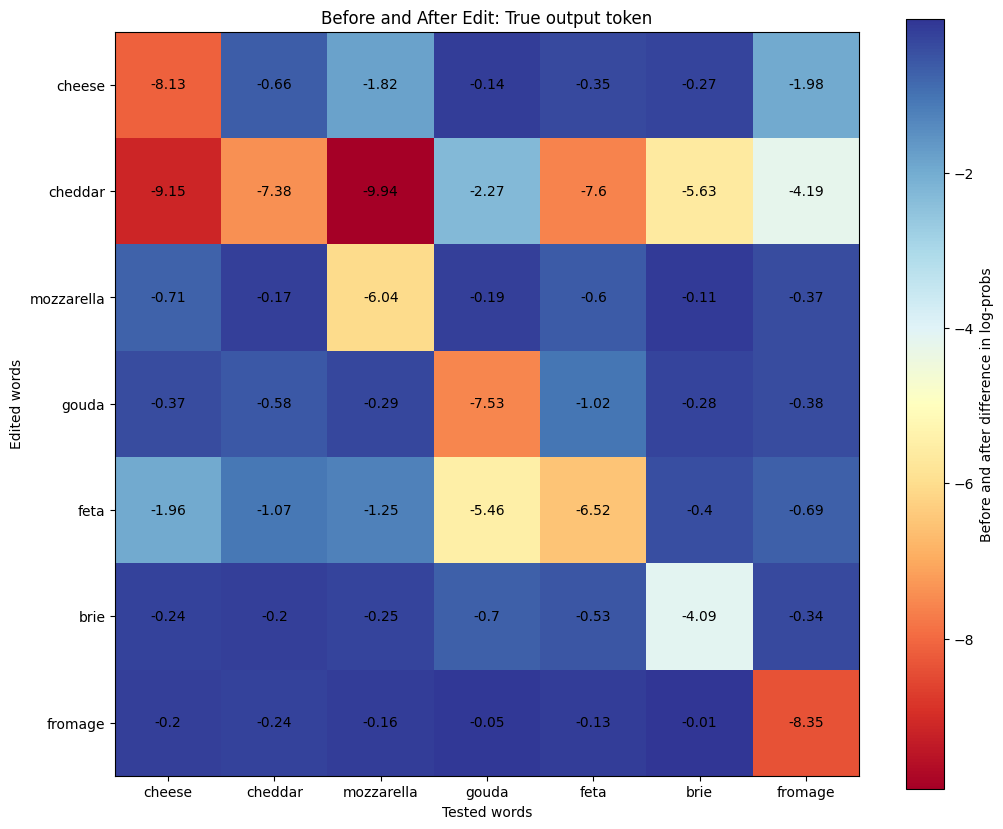

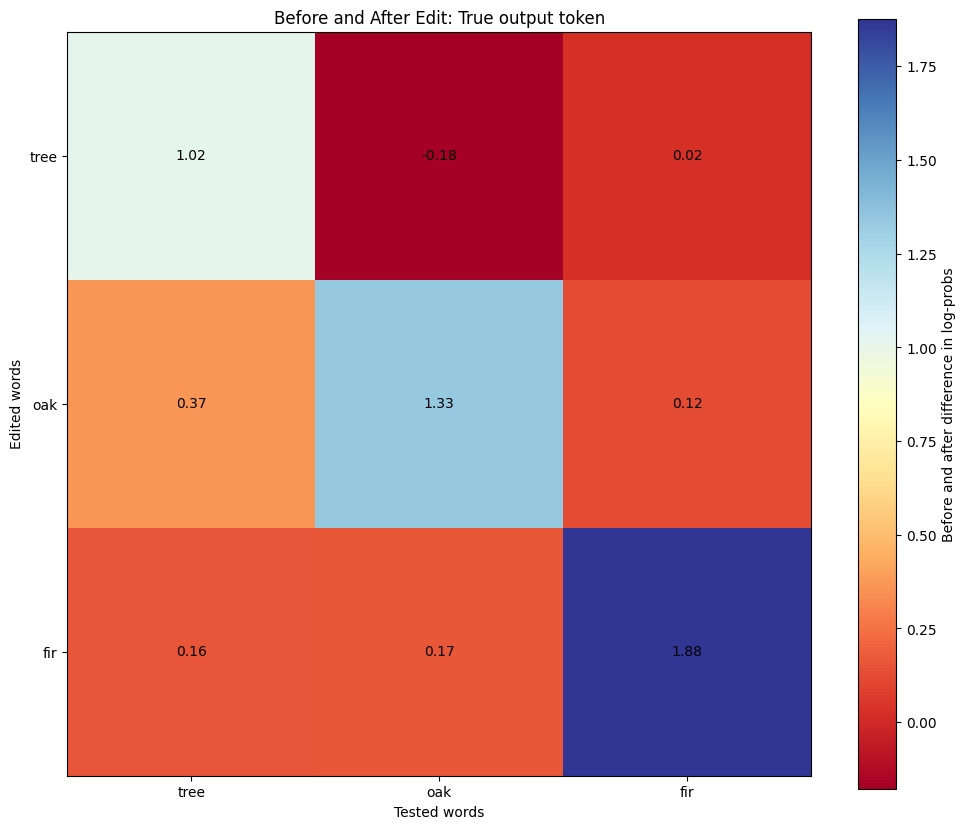

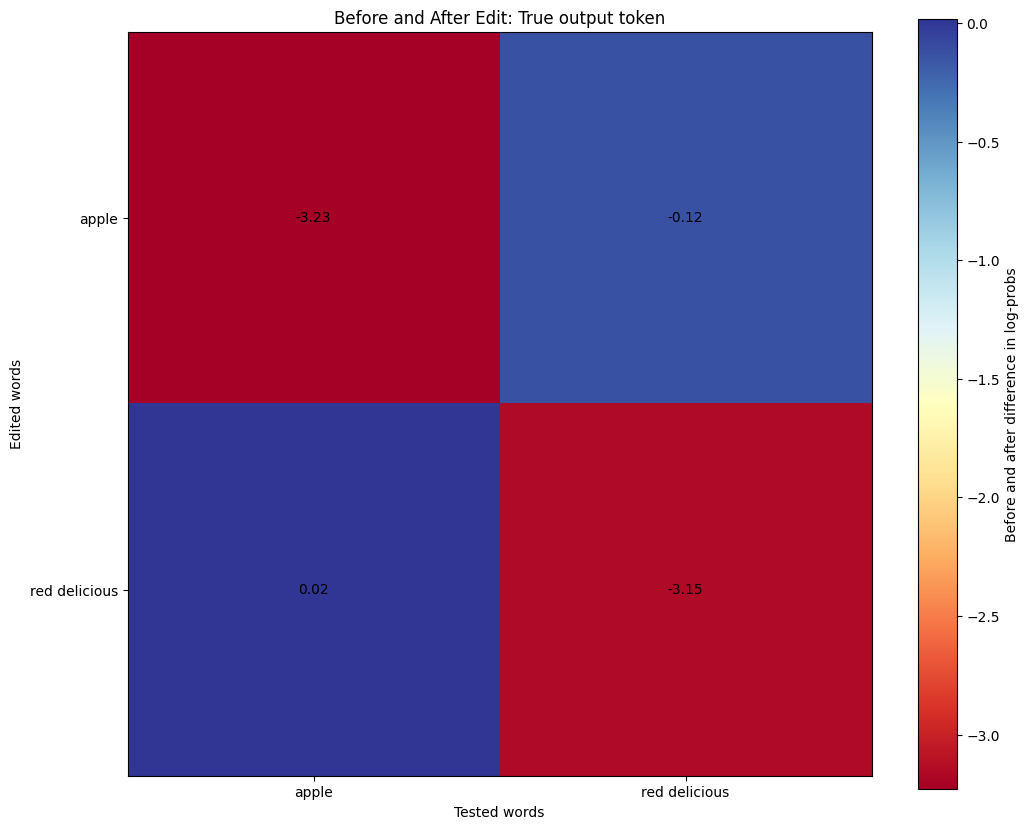

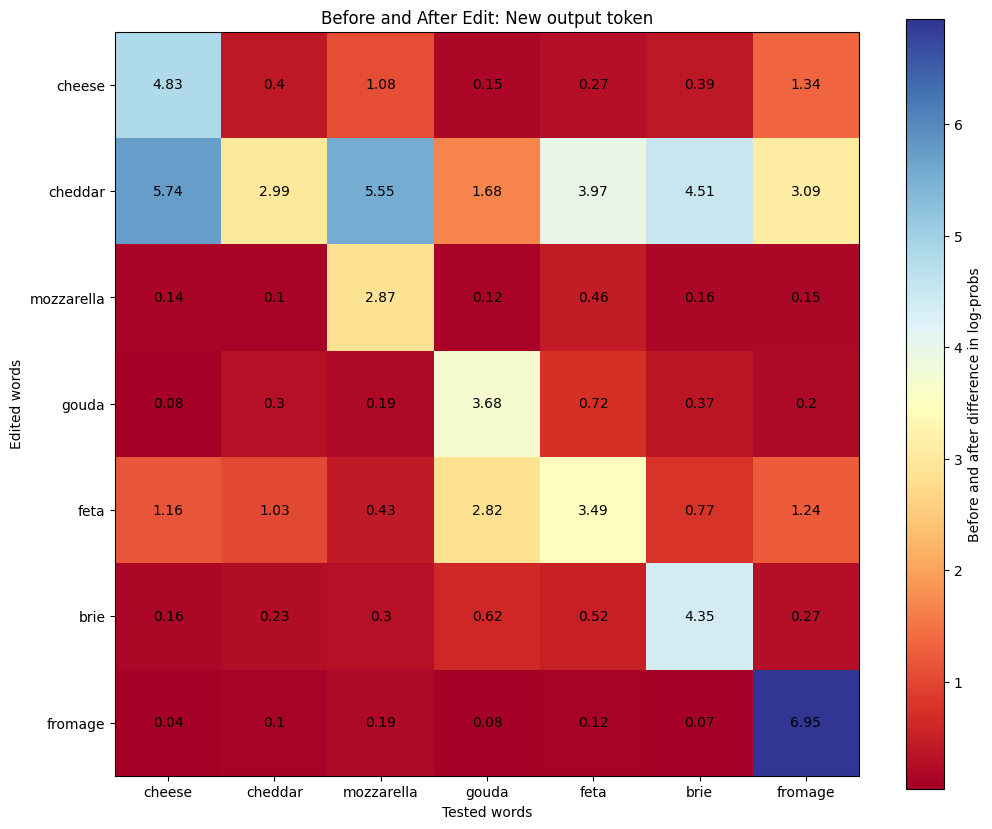

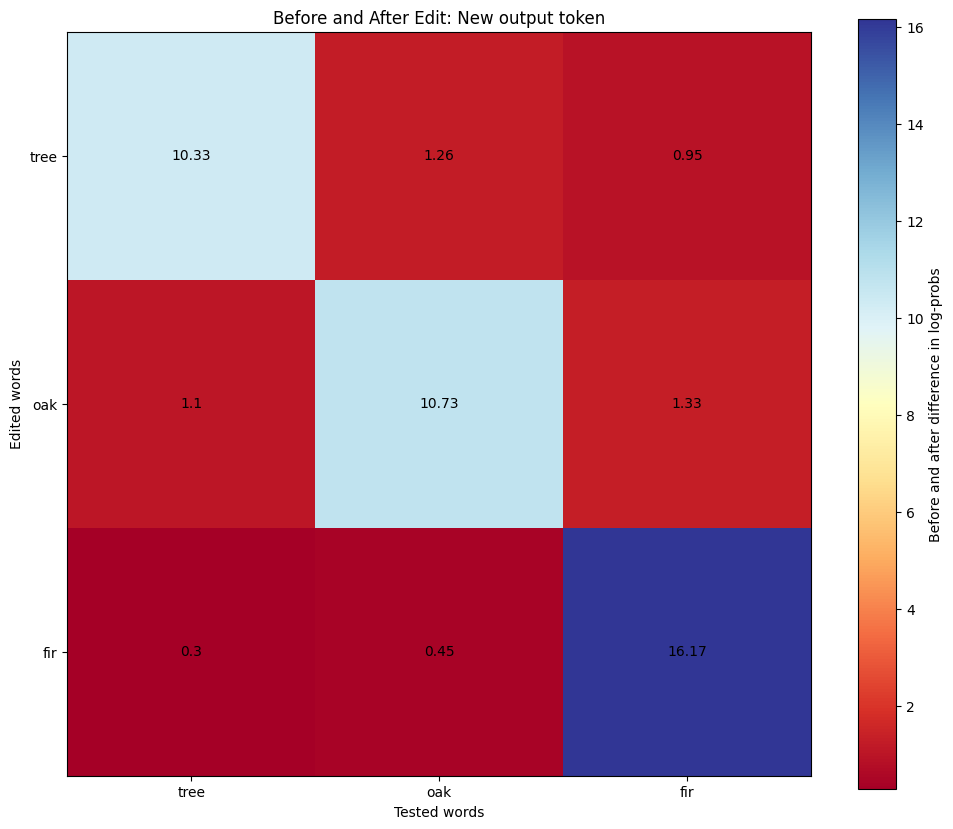

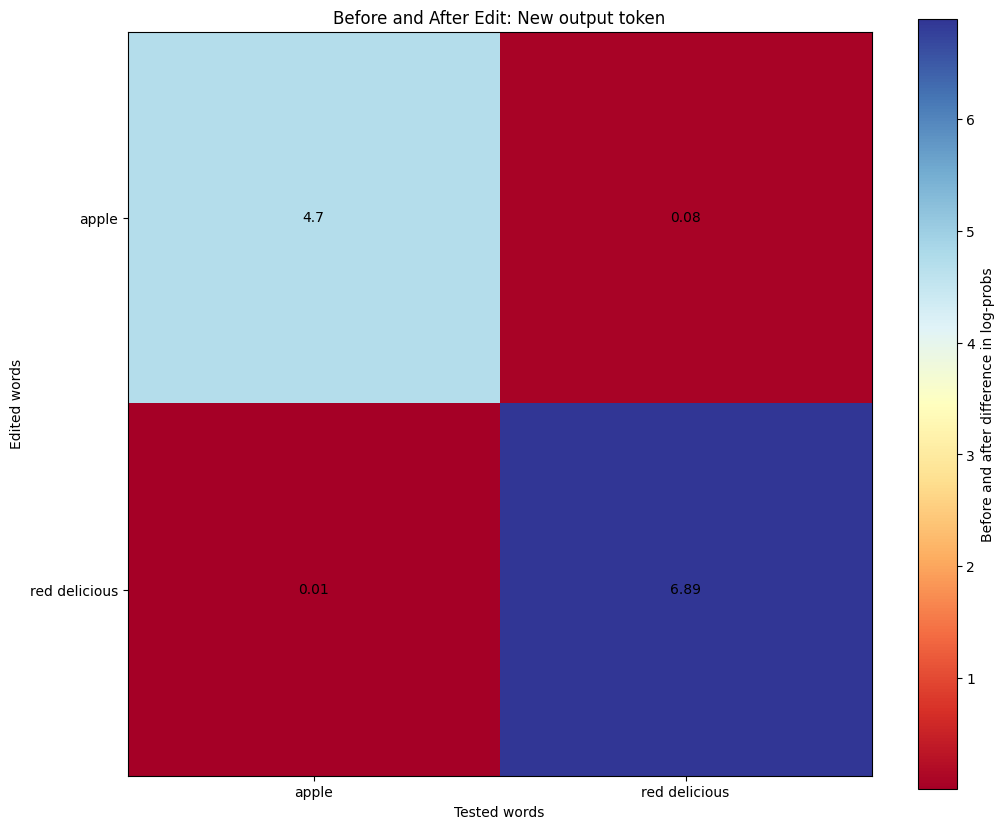

In [308]:
import matplotlib.pyplot as plt
import numpy as np

filename = ["cheese", "tree", "apple"]
plt_sets = ["true_token", "new_token"]
remove_tokens = [4, 3, 2]

# Create some fake data to represent the values in the heatmap
for plot_type in plt_sets:
    for num, k in enumerate(list(data_dict.keys())):
        rem = remove_tokens[num]
        subjects = edits[num]['request'][0]['subjects'][:-rem]
        data = data_dict[k]['log_prob_diff'][plot_type][0]
        # print(data)

        # Create the heatmap using the imshow function
        fig, ax = plt.subplots(figsize=(12, 10))

        # Plot the heatmap
        im = ax.imshow(data, cmap='RdYlBu')

        # Set the tick labels for the x-axis
        ax.set_xticks(np.arange(len(subjects)))
        ax.set_xticklabels(subjects)
        ax.set_xlabel('Tested words')

        # Set the tick labels for the y-axis
        ax.set_yticks(np.arange(len(subjects)))
        ax.set_yticklabels(subjects)
        ax.set_ylabel('Edited words')
        
        if plot_type == "true_token":
            ax.set_title(f"Before and After Edit: True output token")
        else:
            ax.set_title(f"Before and After Edit: New output token")
            

        # Add tick marks and labels to the colorbar
        cbar = fig.colorbar(im)
        cbar.set_label('Before and after difference in log-probs')

        # Add numbers inside each element in the map
        for i in range(len(subjects)):
            for j in range(len(subjects)):
                text = plt.text(j, i, round(data[i][j], 2), ha="center", va="center", color="black")

        plt.savefig(f'{filename[num]}_{plot_type}_01.png')
        plt.show()
        # break

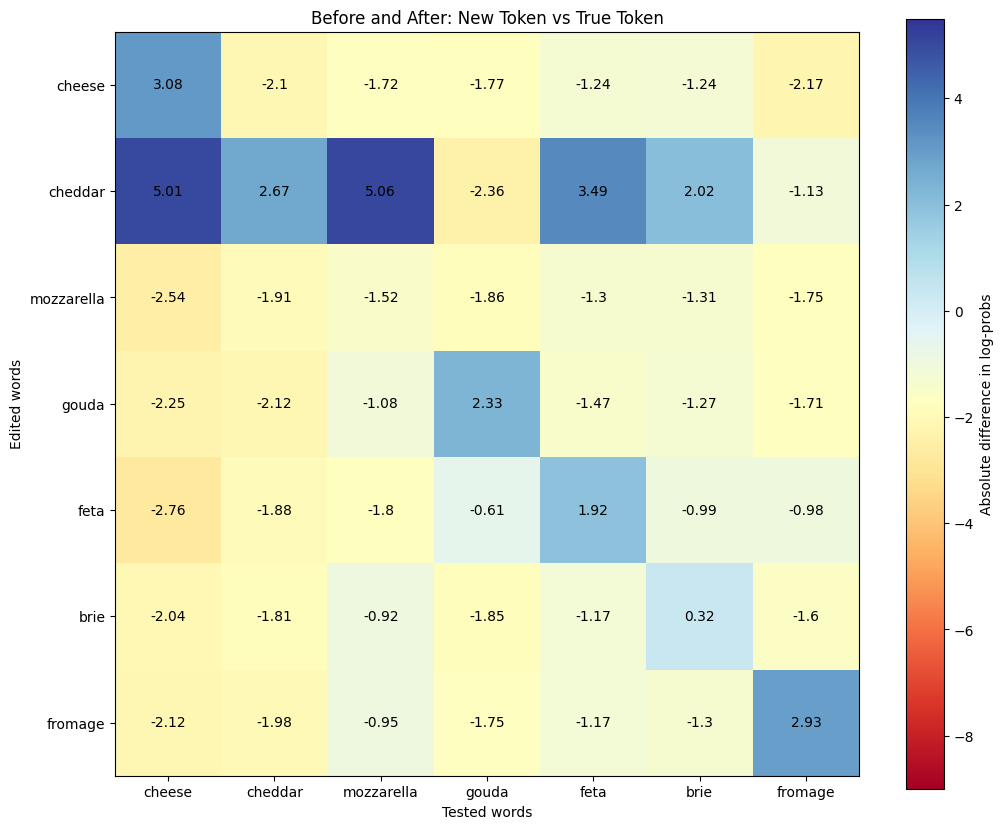

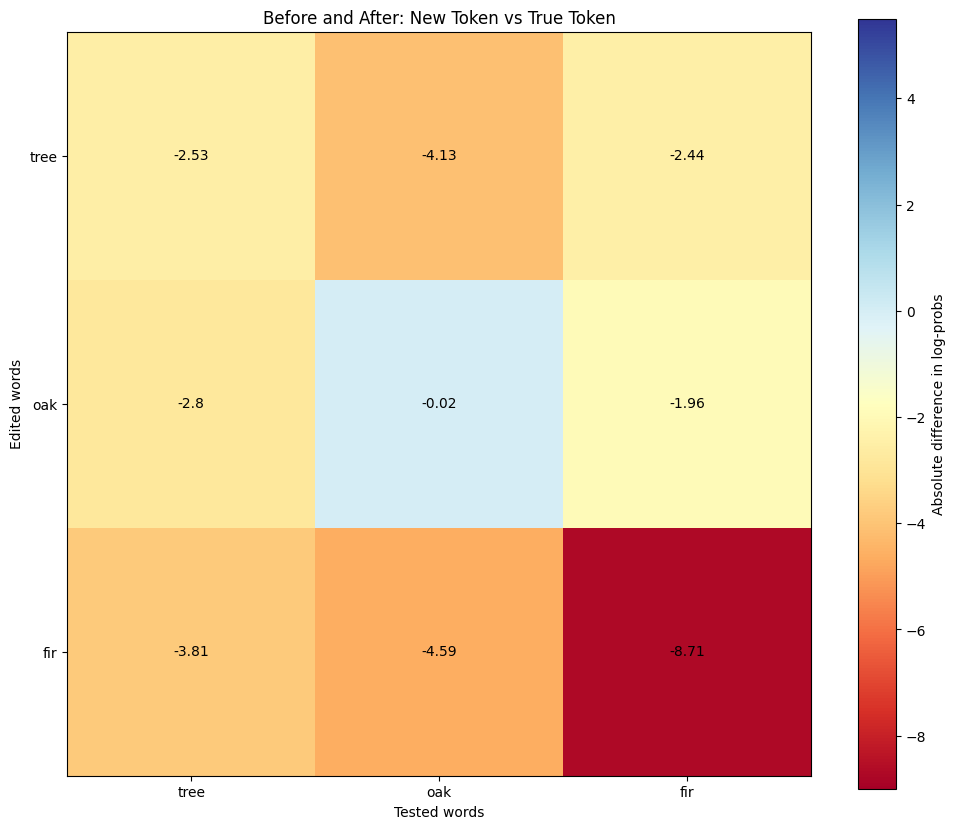

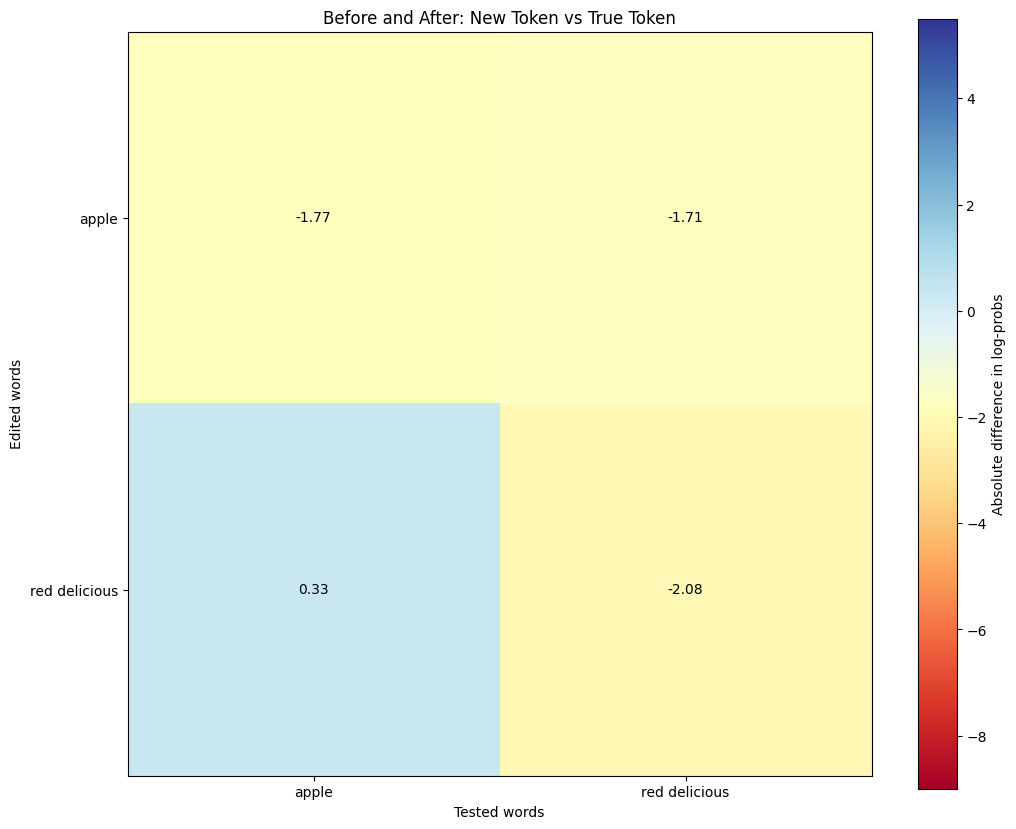

In [312]:
# Create some fake data to represent the values in the heatmap
for num, k in enumerate(list(data_dict.keys())):
    rem = remove_tokens[num]
    subjects = edits[num]['request'][0]['subjects'][:-rem]
    data_true = np.array(data_dict[k]['after_edit']['true_token'][0])
    data_new = np.array(data_dict[k]['after_edit']['new_token'][0])
    diff = list(map(lambda x, y: np.abs(x) - np.abs(y), data_true, data_new))

    # Create the heatmap using the imshow function
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the heatmap
    im = ax.imshow(diff, cmap='RdYlBu',vmin=-9, vmax=5.5)

    # Set the tick labels for the x-axis
    ax.set_xticks(np.arange(len(subjects)))
    ax.set_xticklabels(subjects)
    ax.set_xlabel('Tested words')

    # Set the tick labels for the y-axis
    ax.set_yticks(np.arange(len(subjects)))
    ax.set_yticklabels(subjects)
    ax.set_ylabel('Edited words')
    
    ax.set_title(f"Before and After: New Token vs True Token")

    # Add tick marks and labels to the colorbar
    cbar = fig.colorbar(im)
    cbar.set_label('Absolute difference in log-probs')

    # Add numbers inside each element in the map
    for i in range(len(subjects)):
        for j in range(len(subjects)):
            text = plt.text(j, i, round(diff[i][j], 2), ha="center", va="center", color="black")

    plt.savefig(f'{filename[num]}_new_vs_true_01.png')
    plt.show()
    # break